torch.Size([100, 1, 28, 28]) torch.Size([100])


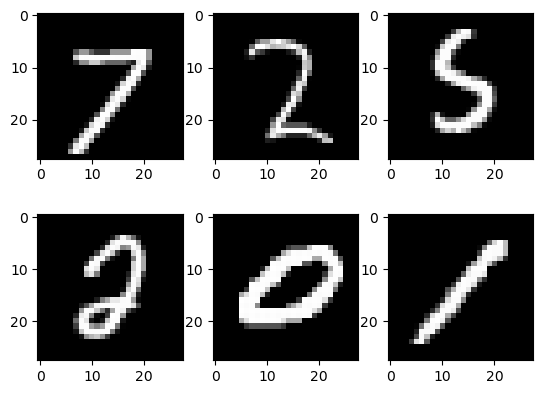

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
input_size = 784 # 28x28 since need to flatten input from 2D to 1D tensor
hidden_size = 100 # can try different sizes
num_classes = 10 # number of categories, since 10 digits
num_epochs = 2 # number of times that the full dataset is trained
batch_size = 100 # number of training data samples for each iteration
learning_rate = 0.001 # magnitude of the change in the weights during update

# MNIST dataset
# convert image data to tensors to use in model
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(train_loader) # to iterate through samples
samples, labels = next(examples)
print(samples.shape, labels.shape) 
# samples.shape returns batch sample size 100, 1 channel (color information, only 1 since grayscale), 28x28 2D image array and labels.shape 100 (1 value per sample)

for i in range(6):
    plt.subplot(2,3, i+1) # plot image samples with 2 rows and 3 columns (since 6 images), and index i+1
    plt.imshow(samples[i][0], cmap='gray') # show each sample's data (only element 0 since 1 channel) and colormap (grayscale)
plt.show()

In [12]:
class NeuralNet(nn.Module): # custom neural net derived from pytorch
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) # layer 1 uses linear function on neurons using input
        self.relu = nn.ReLU() # activation function, decides how the neurons in next layer activate based on factoring in weights and activations of previous neurons (converts activation values to range 0 to +)
        self.l2 = nn.Linear(hidden_size, num_classes) # layer 2 uses linear function on neurons to return output
    
    def forward(self, x): # trains by going forward through neural net to calculate initial output values
        out = self.l1(x) # apply layer 1 on input neurons
        out = self.relu(out) 
        out = self.l2(out) # apply layer 2 on layer 1 output neurons to get class values
        return out 

In [13]:
model = NeuralNet(input_size, hidden_size, num_classes)

# uses cross entropy loss which for each sample averages the actual class Y  * log(predicted class probability Y-hat)
# then uses softmax to get standardized probabilities for each of the classes within range 0-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # optimizer to update weights using gradients calculated from loss

# train samples
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device) # reshape images array from 100,1,28,28 to 100,784 due to input size 784
        labels = labels.to(device)

        # forward pass through neural network to get initial output class values
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backpropagation to calculate gradients and then update weights 
        # find gradient d Loss / dw from output layer to input layer, via chain rule applied to equation applying weights to activations and to activation function applied on that result
        optimizer.zero_grad() # avoids adding gradients from previous sample to current
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0: # print for every 100 samples
            print(f'epoch {epoch + 1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')

epoch 1 / 2, step 100 / 600, loss = 0.5903
epoch 1 / 2, step 200 / 600, loss = 0.2940
epoch 1 / 2, step 300 / 600, loss = 0.4282
epoch 1 / 2, step 400 / 600, loss = 0.2047
epoch 1 / 2, step 500 / 600, loss = 0.1896
epoch 1 / 2, step 600 / 600, loss = 0.2832
epoch 2 / 2, step 100 / 600, loss = 0.1688
epoch 2 / 2, step 200 / 600, loss = 0.1812
epoch 2 / 2, step 300 / 600, loss = 0.1412
epoch 2 / 2, step 400 / 600, loss = 0.1915
epoch 2 / 2, step 500 / 600, loss = 0.1852
epoch 2 / 2, step 600 / 600, loss = 0.1377


In [14]:
# test performance
with torch.no_grad(): # don't need to store gradient calculations for memory efficiency
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device) # reshape images array from 100,1,28,28 to 100,784 due to input size 784
        labels = labels.to(device)
        outputs = model(images)

        # find max probabilities for classes along dimension 1, returns values and indexes (labels) so store indexes in predictions
        _, predictions = torch.max(outputs, 1) 
        n_samples += labels.shape[0] # adds num samples in current batch
        n_correct += (predictions == labels).sum().item() # adds 1 for each correct prediction

    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}') # accuracy is around 95% initially without any model adjustments

accuracy = 95.1
